# Описание проекта

Задача: 
- выявить паттерн поведения пользователей интернет-магазина продуктов питания;
- проанализировать результаты А/А/В эксперимента по эффективности смены шрифта для приложения

# План исследования

1. Предобработка данных
2. Исследование воронки событий
3. Анализ реультатов эксперимента
4. Формирование рекомендаций для бизнеса

# Изучение и предобработка данных

In [1]:
#Импортируем библиотеки
import pandas as pd
import datetime as dt
import numpy as np
from datetime import datetime, date, time
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
import scipy.stats as stats
import math as mth

In [2]:
#Загружаем таблицу с данными
try:
    data = pd.read_csv('logs_exp.csv', sep ='\t')
except:
    data = pd.read_csv('/datasets/logs_exp.csv', sep ='\t')

In [3]:
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
#Смотрим информацию по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
#данные полные, пропусков нет
#приведем названия столбцов к единому стилю
data.columns = ['event_name', 'device_id', 'event_ts', 'exp_id']

In [6]:
#добавим столбец с датой и временем
data['dt'] = pd.to_datetime(data['event_ts'], unit="s")
#добавим отдельный столбец с датой
data['date'] = data['dt'].dt.date

In [7]:
# проверяем таблицу на наличие дубликатов
data.duplicated().sum()

413

In [8]:
# удаление дубликатов
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

In [9]:
#проверяем таблицу на наличие пропусков
data.isna().sum()

event_name    0
device_id     0
event_ts      0
exp_id        0
dt            0
date          0
dtype: int64

In [10]:
#смотрим, сколько событий в логе
data['event_name'].nunique()

5

In [11]:
#cколько всего пользователей в логе
data['device_id'].nunique()

7551

In [12]:
#cколько в среднем событий приходится на пользователя
event_avg = data.groupby('device_id').agg({'event_name':'count'})
event_avg['event_name'].mean()

32.27559263673685

In [13]:
#найдем максимальную и минимальную дату в таблице
data['date'].min()

datetime.date(2019, 7, 25)

In [14]:
data['date'].max()

datetime.date(2019, 8, 7)

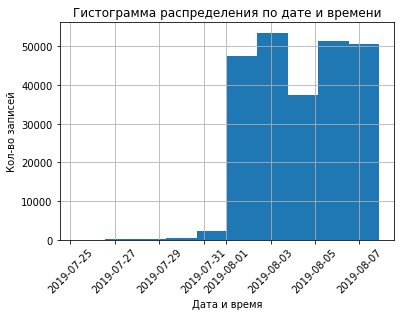

In [15]:
#построим гистограмму по дате и времени
data['dt'].hist()
plt.xticks(rotation = 45)
plt.title('Гистограмма распределения по дате и времени')
plt.xlabel('Дата и время')
plt.ylabel('Кол-во записей');

Поскольку нельзя быть уверенным, что у нас одинаково полные данные за весь период, так как технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Судя по графику, данные полные с 1 августа 2019. Отбросим более старые данные.

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_ts    243713 non-null  int64         
 3   exp_id      243713 non-null  int64         
 4   dt          243713 non-null  datetime64[ns]
 5   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


In [17]:
data['date'] = pd.to_datetime(data['date'])
data_new = data[(data['date'] > '2019-07-31')]
data_new

,event_name,device_id,event_ts,exp_id,dt,date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [18]:
#выведем долю отфильтрованных данных
print('Потери в количестве событий после "чистки":', len(data) - len(data_new))
print(f'Процент потерянных событий:','{0:.2%}'.format((len(data) - len(data_new)) / len(data)))
print('Потери в количестве уникальных пользователей приложения после "чистки":', 
      data['device_id'].nunique() - data_new['device_id'].nunique())
print(f'Процент потерянных пользователей:',
      '{0:.2%}'.format((data['device_id'].nunique() - data_new['device_id'].nunique())/data['device_id'].nunique()))

Потери в количестве событий после "чистки": 2826
Процент потерянных событий: 1.16%
Потери в количестве уникальных пользователей приложения после "чистки": 17
Процент потерянных пользователей: 0.23%


In [19]:
#сколько пользователей попало в каждую из экспериментальных групп 
groups = data_new.groupby('exp_id').agg({'device_id':'nunique'})
groups

,device_id
exp_id,
246,2484
247,2513
248,2537


## Вывод по разделу

В результате предобработки датафрейм имеет 6 колонок с действиями пользователя в приложении. 
Всего строк в таблице 241298. 

В дальнейшем мы будем анализировать данные за период с 1 по 7 августа 2019 года. 
Во всех трех экспериментальных группах есть примерно одинаковое количество пользователей (~2500).

# Исследование воронки событий

In [20]:
#посмотрим, какие события есть в логах и как часто они встречаются
data_new['event_name'].value_counts().sort_values(ascending=False)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [21]:
#сколько пользователей совершали каждое из этих событий
users = data_new.groupby('event_name').agg({'device_id':'nunique'}).sort_values('device_id', ascending=False)
users['proportion'] = users['device_id']/users['device_id'].sum()*100
users['proportion'] = users['proportion'].round(2)
users

,device_id,proportion
event_name,,
MainScreenAppear,7419,36.86
OffersScreenAppear,4593,22.82
CartScreenAppear,3734,18.55
PaymentScreenSuccessful,3539,17.59
Tutorial,840,4.17


Судя по табличке самым популярным действием является посещение главной страницы (MainScreenAppear) - его совершили 117431 раз 7419 пользователей (~37%). 

Далее идет посещение страницы с товаром (OffersScreenAppear) - 46350 раз на него зашли 4593 посетителей (~23%).

Страницу с корзиной (CartScreenAppear) посетили 3734 пользователей (~19%) 42365 раз.

Успешно оплатили заказ (PaymentScreenSuccessful) 3539 клиентов (~18%) 34113 раз.

И наименее популярным у пользователей действием является прохождение обучения по пользованию сайтом (Tutorial). Им воспользовалось 840 клиентов (~4%) 1039 раз.

Скорее всего пользователь сначала должен пройти туториал, потом открывается главная страница, затем пользователь заходит на страничку понравившегося товара, после этого он должен добавить его в корзину, зайти в корзину, оплатить товар и увидеть страничку успешной оплаты. Однако, прохождение обучения не является обязательным шагом и не входит в воронку. В дальнейшем мы не будем учитывать это действие. 

In [22]:
#фильтруем данные, убрав tutorial из датасета
data_filtered = data_new.query('event_name != "Tutorial"').copy()
data_filtered['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Name: event_name, dtype: int64

In [23]:
# определяем переменные для создания воронки
funnel_A1 = data_filtered[data_filtered['exp_id'] == 246].groupby('event_name').agg({'event_name':'count', 'device_id':'nunique'})
funnel_A1.columns = ['event_count','user_count']
funnel_A1 = funnel_A1.sort_values(by = 'event_count', ascending = False).reset_index()

funnel_A2 = data_filtered[data_filtered['exp_id']==247].groupby('event_name').agg({'event_name':'count', 'device_id':'nunique'})
funnel_A2.columns = ['event_count','user_count']
funnel_A2 = funnel_A2.sort_values(by = 'event_count', ascending = False).reset_index()

funnel_B = data_filtered[data_filtered['exp_id']==248].groupby('event_name').agg({'event_name':'count', 'device_id':'nunique'})
funnel_B.columns = ['event_count','user_count']
funnel_B = funnel_B.sort_values(by = 'event_count', ascending = False).reset_index()

In [24]:
funnel_A1['shift'] = funnel_A1['user_count'].shift(1)

#добавим колонку с долей переходов с шага на шаг
funnel_A1['step_conv'] = funnel_A1['user_count']/funnel_A1['shift']*100 
funnel_A1['step_conv'] = funnel_A1['step_conv'].round(2)

#добавим колонку с общей конверсией
funnel_A1['conversion'] = funnel_A1['user_count']/2450*100
funnel_A1['conversion'] = funnel_A1['conversion'].round(2)
funnel_A1

,event_name,event_count,user_count,shift,step_conv,conversion
0,MainScreenAppear,37676,2450,NaN,NaN,100.00
1,OffersScreenAppear,14767,1542,2450.0,62.94,62.94
2,CartScreenAppear,14690,1266,1542.0,82.10,51.67
3,PaymentScreenSuccessful,11852,1200,1266.0,94.79,48.98


In [25]:
funnel_A2['shift'] = funnel_A2['user_count'].shift(1)

#добавим колонку с долей переходов с шага на шаг
funnel_A2['step_conv'] = funnel_A2['user_count']/funnel_A2['shift']*100 
funnel_A2['step_conv'] = funnel_A2['step_conv'].round(2)

#добавим колонку с общей конверсией
funnel_A2['conversion'] = funnel_A2['user_count']/2476*100
funnel_A2['conversion'] = funnel_A2['conversion'].round(2)
funnel_A2

,event_name,event_count,user_count,shift,step_conv,conversion
0,MainScreenAppear,39090,2476,NaN,NaN,100.00
1,OffersScreenAppear,15179,1520,2476.0,61.39,61.39
2,CartScreenAppear,12434,1238,1520.0,81.45,50.00
3,PaymentScreenSuccessful,9981,1158,1238.0,93.54,46.77


In [26]:
funnel_B['shift'] = funnel_B['user_count'].shift(1)

#добавим колонку с долей переходов с шага на шаг
funnel_B['step_conv'] = funnel_B['user_count']/funnel_B['shift']*100 
funnel_B['step_conv'] = funnel_B['step_conv'].round(2)

#добавим колонку с общей конверсией
funnel_B['conversion'] = funnel_B['user_count']/2493*100
funnel_B['conversion'] = funnel_B['conversion'].round(2)
funnel_B

,event_name,event_count,user_count,shift,step_conv,conversion
0,MainScreenAppear,40562,2493,NaN,NaN,100.00
1,OffersScreenAppear,16387,1531,2493.0,61.41,61.41
2,CartScreenAppear,15179,1230,1531.0,80.34,49.34
3,PaymentScreenSuccessful,12085,1181,1230.0,96.02,47.37


In [1]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A1', 
    y = funnel_A1['event_name'],
    x = funnel_A1['user_count'],
    marker = {"color": "pink"},
    textinfo = "value+percent initial+percent previous"))

fig.add_trace(go.Funnel(
    name = 'A2',
    orientation = "h",
    y = funnel_A2['event_name'],
    x = funnel_A2['user_count'],
    textposition = "inside",
    marker = {"color": "purple"},
    textinfo = "value+percent initial+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = funnel_B['event_name'],
    x = funnel_B['user_count'],
    textposition = "inside",
    marker = {"color": "teal"},
    textinfo = "value+percent initial+percent previous"))

fig.update_layout(title_text='Воронка конверсии событий по группам', title_x=0.7)
fig.show()

NameError: name 'go' is not defined

## Вывод по разделу

- Почти половина пользователей доходит до оплаты товара. И лидирует здесь группа А1 (первая контрольная группа)
- Наибольший процент клиентов теряется уже на втором шаге, когда нужно перейти с главной страницы на страницу предложения(товара) - то есть около 40% клиентов мы теряем!
- Самая большая конверсия при переходе на последний шаг - ~95% пользователей, добавивших товар в корзину, оплачивают его.

# Анализ реультатов A/A/B эксперимента

In [28]:
data_new.groupby('device_id').agg({'exp_id':'nunique'}).query('exp_id > 1').reset_index()

,device_id,exp_id


Пользователи в группах не пересекаются.

In [29]:
#cчитаем пользователей в каждой группе
group_size = (
    data_new
    .groupby('exp_id')
    .agg({'device_id': 'nunique'})
    .reset_index()
    .rename(columns={'device_id':'number_of_users'})
)
group_size

,exp_id,number_of_users
0,246,2484
1,247,2513
2,248,2537


Посчитаем статистическую значимость различий между выборками 246 (А1) и 247(А2). Сформулируем гипотезы.

- Нулевая: различий в выборках между группами А1 и А2 нет.
- Альтернативная: различия в выборках между группами есть.

In [30]:
users_by_events = (
    data_new
    .pivot_table(index = 'exp_id',
                 columns = 'event_name',
                 values = 'device_id',
                 aggfunc = 'nunique')
    .reset_index()
)

# добавляем столбец с количеством пользователей в группах
users_by_events['number_of_users'] = group_size['number_of_users']

users_by_events

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,number_of_users
0,246,1266,2450,1542,1200,278,2484
1,247,1238,2476,1520,1158,283,2513
2,248,1230,2493,1531,1181,279,2537


Cравним доли клиентов групп 246 и 247, оплативших заказ. Из 2483 пользователей группы 246, заказ оплатили 1200 человек; а из 2512 пользователей группы 247 заказ оплатили 1158. Попробуем сделать вывод о разнице в конверсии для этих групп. Для начала сформулируем гипотезы:

- H₀ - различий в долях клиентов, оплативших заказ между группами нет;
- H₁ - различия в долях клиентов, оплативших заказ между группами есть.

In [31]:
# формирование вспомогательной функции для вывода результатов теста
def test_result(value_1, value_2):
    if value_1 < value_2:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

# формирование функции
def hypo_test (trials_1, trials_2, successes_1, successes_2, alpha):
    
    # пропорция успехов в первой группе
    p1 = successes_1/trials_1
    
    # пропорция успехов во второй группе
    p2 = successes_2/trials_2

    # пропорция успехов в комбинированном датасете
    p_combined = (successes_1 + 
                  successes_2) / (trials_1 + 
                                 trials_2)

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * 
                                    (1 - p_combined) * 
                                    (1 / trials_1 + 1 / trials_2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    pr_1 = print('p-значение: ', p_value)
    
    pr_2 = test_result(p_value, alpha)
    
    return pr_1, pr_2

Проведем проверку гипотез, запустив функцию для групп 246 и 247 и назначив уровень стат. значимости равный 0.05.

In [32]:
print('**Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events.columns[5], 'в группах 246 и 247**')
hypo_test (users_by_events.iloc[0,6],
           users_by_events.iloc[1,6],
           users_by_events.iloc[0,4],
           users_by_events.iloc[1,4], 0.05)

**Проверка гипотезы о различиях в долях клиентов по событию Tutorial в группах 246 и 247**
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


(None, None)

Cтатистически значимых различий между двумя А-группами не обнаружено.

Выберем самое популярное событие - MainScreenAppear - появление главного экрана. Количество пользователей в группах, совершивших данное событие мы определили, осталось посчитать доли от общего количества пользователей по группам.

In [33]:
# сформируем вспомогательную таблицу
top = users_by_events[['exp_id', 'MainScreenAppear', 'number_of_users']].copy()
top['proportion'] = round(top['MainScreenAppear'] / top['number_of_users'], 3)
top

event_name,exp_id,MainScreenAppear,number_of_users,proportion
0,246,2450,2484,0.986
1,247,2476,2513,0.985
2,248,2493,2537,0.983


Почти каждый пользователь приложения попадал на главный экран.

Проверим, будет ли отличие между группами 246 и 247 статистически достоверным.

In [34]:
print('**Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events.columns[3], 'в группах 246 и 247**')
hypo_test (users_by_events.iloc[0,6], 
           users_by_events.iloc[1,6], 
           users_by_events.iloc[0,2], 
           users_by_events.iloc[1,2], 0.05)

**Проверка гипотезы о различиях в долях клиентов по событию OffersScreenAppear в группах 246 и 247**
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


(None, None)

Cтатистически значимых различий между группами 246 и 247 по результатам проверки различий в долях клиентов, взаимодействующих с главным экраном, не обнаружено.

Проведем проверку по остальным событиям: OffersScreenAppear и CartScreenAppear.

In [35]:
column_list = [3, 1, 5]
for column_number in column_list:
    print('**Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events.columns[column_number], 'в группах 246 и 247**')
    hypo_test (users_by_events.iloc[0,6],
               users_by_events.iloc[1,6],
               users_by_events.iloc[0,column_number],
               users_by_events.iloc[1,column_number], 0.05)
    print('\n')

**Проверка гипотезы о различиях в долях клиентов по событию OffersScreenAppear в группах 246 и 247**
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию CartScreenAppear в группах 246 и 247**
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию Tutorial в группах 246 и 247**
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




По результатам проверок можно сделать вывод, что статистически значимых различий между группами 246 и 247 нет и группы разбиты корректно.

Сравним результаты группы 248 с каждой из групп 246 и 247 в отдельности по каждому событию.

In [36]:
column_list = [2, 3, 1, 4, 5]
for column_number in column_list:
    print('**Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events.columns[column_number], 'в группах 246 и 248**')
    hypo_test (users_by_events.iloc[0,6],
               users_by_events.iloc[2,6],
               users_by_events.iloc[0,column_number],
               users_by_events.iloc[2,column_number], 0.05)
    print('\n')
    print('**Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events.columns[column_number], 'в группах 247 и 248**')
    hypo_test (users_by_events.iloc[1,6],
               users_by_events.iloc[2,6],
               users_by_events.iloc[1,column_number],
               users_by_events.iloc[2,column_number], 0.05)
    print('\n')
    print('\n')


**Проверка гипотезы о различиях в долях клиентов по событию MainScreenAppear в группах 246 и 248**
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию MainScreenAppear в группах 247 и 248**
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




**Проверка гипотезы о различиях в долях клиентов по событию OffersScreenAppear в группах 246 и 248**
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию OffersScreenAppear в группах 247 и 248**
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




**Проверка гипотезы о различиях в долях клиентов по событию CartScreenAppear в группах 246 и 248**
p-значение:  0.07842923237520116
Не получилось о

По результатам проверок видно, что статистически значимых различий между группами 246, 247 и 248 нет. Предварительно можно сделать вывод, что замена шрифта не повлияла на пользователей

Добавим в таблицу users_by_events строку с данными по объединённой контрольной группе 246_247 для сравнения результатов с группой 248.

In [37]:
# дополнение таблицы информацией по объединенной контрольной группе
row_246_247 = users_by_events.loc[0] + users_by_events.loc[1]
users_by_events_total = users_by_events.copy()
users_by_events_total = users_by_events_total.append([row_246_247]).reset_index(drop=True)
users_by_events_total.iloc[3,0] = '246&247'
users_by_events_total

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,number_of_users
0,246,1266,2450,1542,1200,278,2484
1,247,1238,2476,1520,1158,283,2513
2,248,1230,2493,1531,1181,279,2537
3,246&247,2504,4926,3062,2358,561,4997


Сравним результаты группы 248 с объединённой контрольной группой 246_247 в отдельности по каждому событию.

In [38]:
column_list = [2, 3, 1, 4, 5]
for column_number in column_list:
    print('**Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events_total.columns[column_number], 'в группах 246&247 и 248**')
    hypo_test (users_by_events_total.iloc[3,6],
               users_by_events_total.iloc[2,6],
               users_by_events_total.iloc[3,column_number],
               users_by_events_total.iloc[2,column_number], 0.05)
    print('\n')

**Проверка гипотезы о различиях в долях клиентов по событию MainScreenAppear в группах 246&247 и 248**
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию OffersScreenAppear в группах 246&247 и 248**
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию CartScreenAppear в группах 246&247 и 248**
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию PaymentScreenSuccessful в группах 246&247 и 248**
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию Tutorial в группах 246&247 и 248**
p-значение:  0.764862472531507
Не

По результатам проверок можно сделать общий вывод, что статистически значимых различий между группами 246_247 и 248 также нет. Подтвердим вывод, что замена шрифта не повлияла на пользователей.

При проверке статистических гипотез выше мы выбрали уровень значимости равный 0.05. Посчитаем, сколько проверок статистических гипотез мы сделали. Мы провели множественный тест, т.е. брали несколько выборок из одного и того же набора данных. Его особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат.

In [39]:
#сколько проверок статистических гипотез мы сделали
count_stat_hypo = len(users_by_events_total['exp_id'].unique()) * len(data['event_name'].unique())
print('Было сделано проверок статистических гипотез:', count_stat_hypo)

Было сделано проверок статистических гипотез: 20


Определим, какой уровень значимости стоит применить. Выберем метод Шидака, т.к. он наиболее точен. Рассчитаем p-value.

In [40]:
p_value = 1 - (1 - 0.05)**(1 / count_stat_hypo)
print('Уточненый p-value:', p_value)

Уточненый p-value: 0.0025613787765302876


Результаты не поменяются, уточненный p-value получился еще меньше. Внесённые нами изменения никак не повлияли на метрики и на поведения пользователей. Поэтому смысла в их применении ко всему ресурсу нет - они не принесут пользы бизнесу.

# Общий вывод

При проверке результатов А/А/В-теста было проведено 20 проверок статистических гипотез. Опираясь на полученные результаты можно сделать вывод:
- статистически значимых различий между группами 246, 247 и 248 нет;
- нет различий между группами 246_247 и 248.
Был применен уровень статистической значимости, равный 0.05, менять который в нашем случае нет смысла, так как уточненное значение оказалось еще меньше (применён метод Шидака).

Опираясь на результаты проверки можно утверждать, что гипотеза о том, что изменение шрифта на главной странице повлияет на метрики конверсии, не подтвердилась. В связи с этим, возможно, стоит попробовать использовать другой шрифт, или отказаться от идеи менять шрифт в пользу других изменений. Например, вида карточки товара на главной странице приложения, поскольку наибольшее количество клиентов магазина попадают именно на эту страницу. **А судя по воронке конверсии событий, около 40% клиентов теряются на шаге перехода с главной страницы на страницу предложения с товаром.** Скорее всего, именно в том, что вид товара на главной странице не привлекает клиента, есть проблема.